### All imports

In [2]:
import pandas as pd
import numpy as np
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from datetime import datetime
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
df = pd.read_csv('shortData.csv', index_col="Unnamed: 0")

In [4]:
list(df)

['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']

In [5]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
2041,2013-03-14 11:27:28,206.0,99,1
3152,2013-01-03 20:48:24,186.0,6,0
5166,2013-01-19 16:51:27,61.0,1,0
10135,2013-01-26 11:34:23,72.0,116,0
10560,2013-04-29 09:39:50,246.0,245,0


### Removed outliers

In [6]:
df['price_usd'].describe()

count    3049.000000
mean      112.939023
std       113.374049
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max      5584.000000
Name: price_usd, dtype: float64

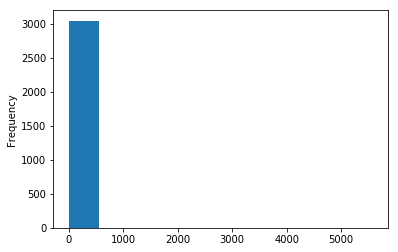

In [7]:
df['price_usd'].plot(kind="hist")

In [8]:
df = df.loc[df['price_usd'] < 5584]

In [9]:
df['price_usd'].describe()

count    3048.000000
mean      111.144055
std        55.055161
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max       536.000000
Name: price_usd, dtype: float64

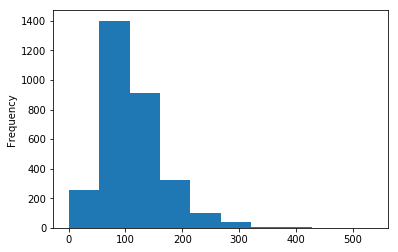

In [10]:
df['price_usd'].plot(kind="hist")

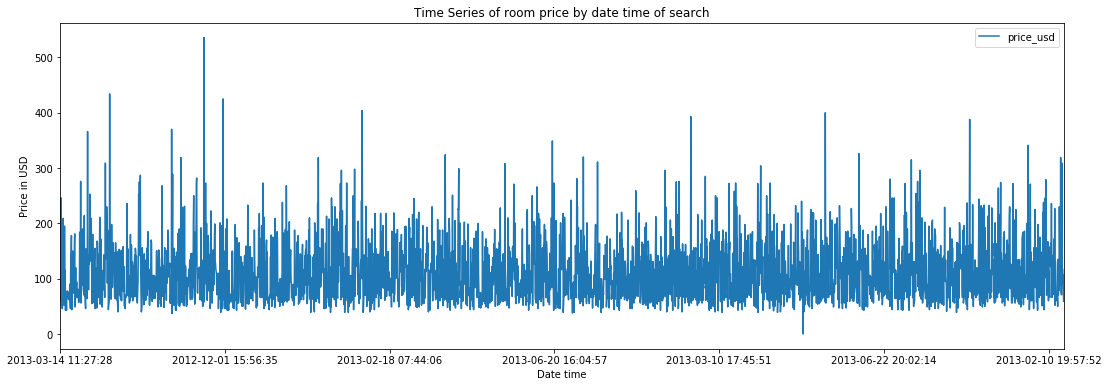

In [11]:
df.plot(x='date_time', y='price_usd', figsize=(18,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search');

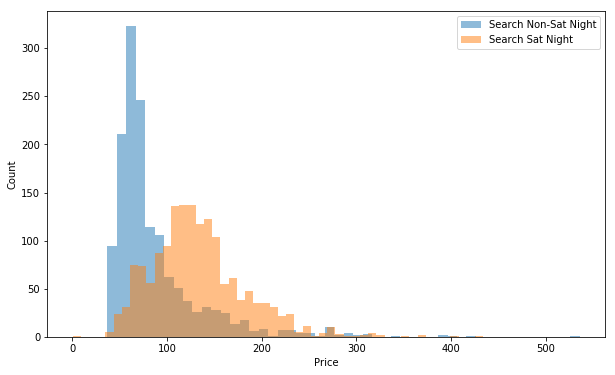

In [12]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

### Clustering

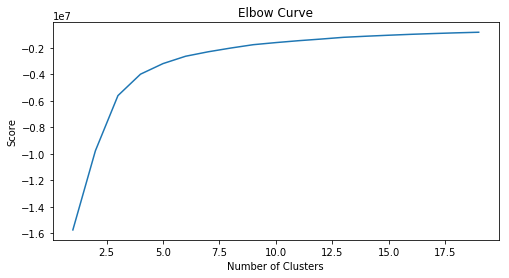

In [13]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

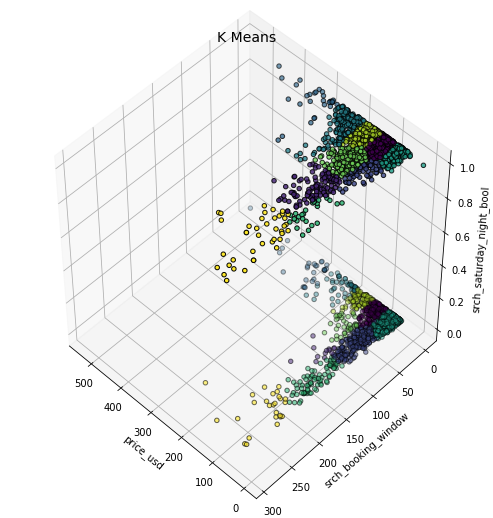

In [14]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
temp=km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

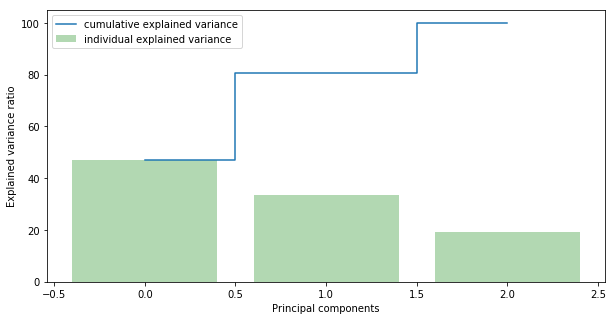

In [15]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [27]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [28]:
data.head()

,0,1
0,1.507151,1.377635
1,0.232739,-0.893155
2,-1.115143,-0.884099
3,-1.148993,1.555646
4,0.564842,4.142935


In [29]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[10].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]


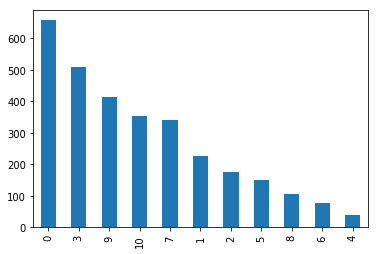

In [30]:
df['cluster'].value_counts(sort=True).plot.bar()

In [31]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principal_feature1,principal_feature2
0,2013-03-14 11:27:28,206.0,99,1,2,1.507151,1.377635
1,2013-01-03 20:48:24,186.0,6,0,9,0.232739,-0.893155
2,2013-01-19 16:51:27,61.0,1,0,0,-1.115143,-0.884099
3,2013-01-26 11:34:23,72.0,116,0,5,-1.148993,1.555646
4,2013-04-29 09:39:50,246.0,245,0,4,0.564842,4.142935


#### Finding the distance from the centroid

In [39]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

data1 = data.reset_index(drop=True)
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data1, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)


C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


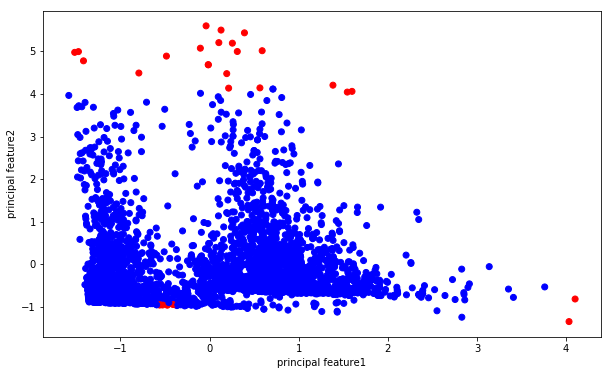

In [41]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [42]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principal_feature1,principal_feature2,anomaly1
0,2013-03-14 11:27:28,206.0,99,1,2,1.507151,1.377635,0
1,2013-01-03 20:48:24,186.0,6,0,9,0.232739,-0.893155,0
2,2013-01-19 16:51:27,61.0,1,0,0,-1.115143,-0.884099,0
3,2013-01-26 11:34:23,72.0,116,0,5,-1.148993,1.555646,0
4,2013-04-29 09:39:50,246.0,245,0,4,0.564842,4.142935,1


In [43]:
data1.head()

,0,1
0,1.507151,1.377635
1,0.232739,-0.893155
2,-1.115143,-0.884099
3,-1.148993,1.555646
4,0.564842,4.142935


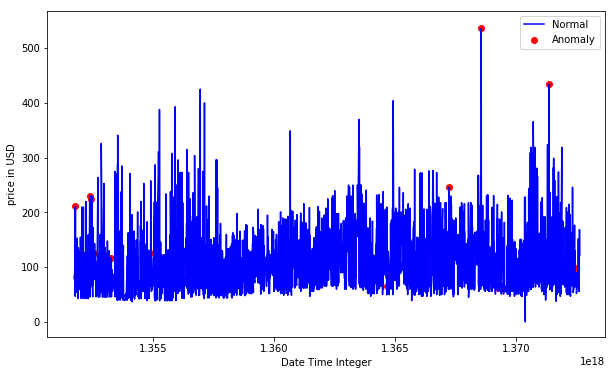

In [45]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

### isolationforest

C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", Deprecatio

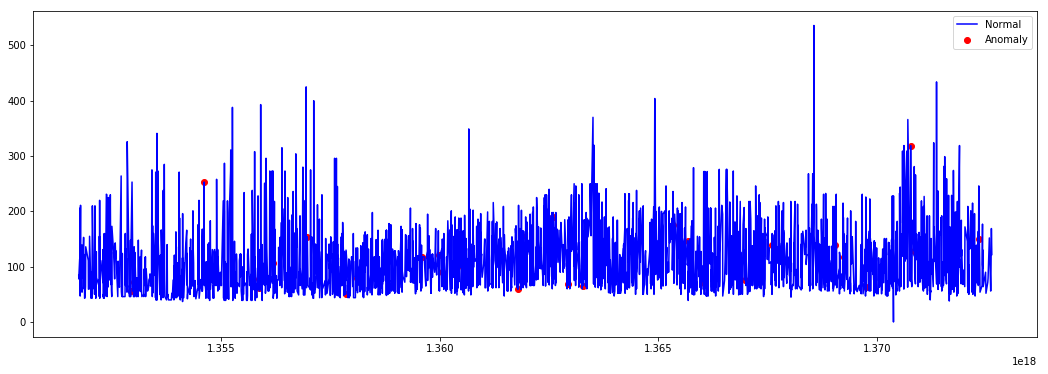

In [46]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df['anomaly2'] = pd.Series(model.predict(data))

# visualization
fig, ax = plt.subplots(figsize=(18,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

### SVM


C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shree\Anaconda3\envs\timeseries\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


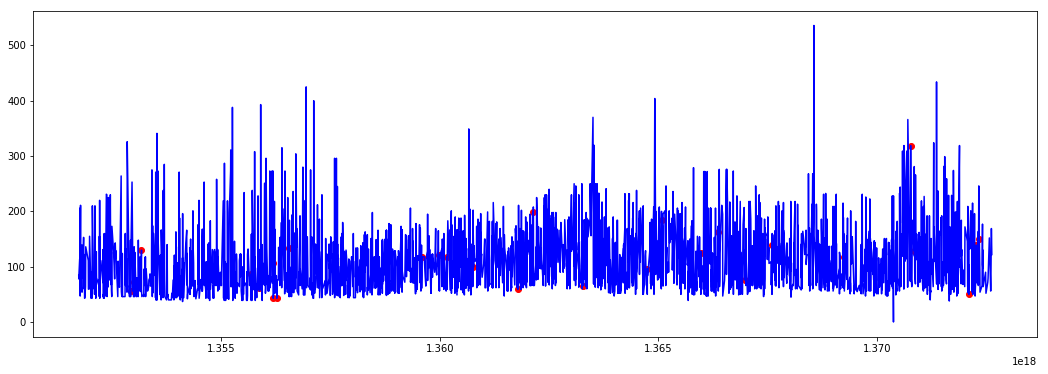

In [47]:

data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
df['anomaly3'] = pd.Series(model.predict(data))

fig, ax = plt.subplots(figsize=(18,6))
a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue')
ax.scatter(a['date_time_int'],a['price_usd'], color='red')
plt.show();

In [48]:
df["anomaly3"].value_counts()

 1    3017
-1      31
Name: anomaly3, dtype: int64

### Gaussian Distribution

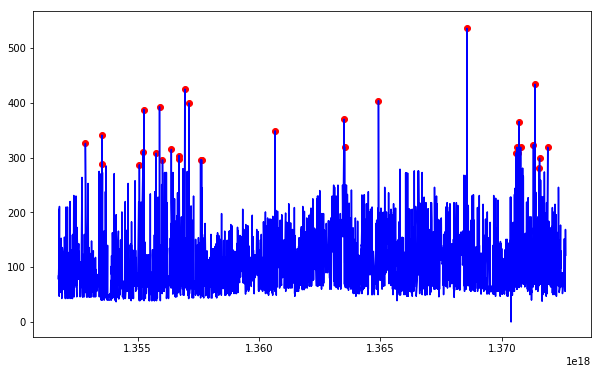

In [49]:

df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

df_class = pd.concat([df_class0, df_class1])
df['anomaly5'] = df_class['anomaly']
fig, ax = plt.subplots(figsize=(10, 6))
a = df.loc[df['anomaly5'] == -1, ('date_time_int', 'price_usd')] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='blue')
ax.scatter(a['date_time_int'],a['price_usd'], color='red')
plt.show();

### loading of data

In [18]:
dataset = pd.read_csv("data_uk.csv")
dataset1= dataset

In [19]:
dataset["Date"] = pd.to_datetime(dataset["DateTime"])
dataset = dataset.set_index("Date")
data=dataset.loc[:, ['KWH/hh (per half hour) ']]
data['KWH/hh (per half hour) '] = pd.to_numeric(data['KWH/hh (per half hour) '],downcast='float',errors='coerce')

In [20]:
data.dtypes

KWH/hh (per half hour)     float32
dtype: object

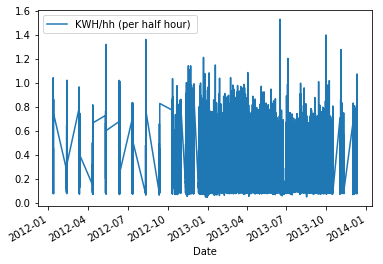

In [21]:
data.plot()

In [22]:
data.dropna().describe()

,KWH/hh (per half hour)
count,17457.000000
mean,0.209008
std,0.157070
min,0.045000
25%,0.105000
50%,0.149000
75%,0.252000
max,1.529000


### Resampling week and day wise

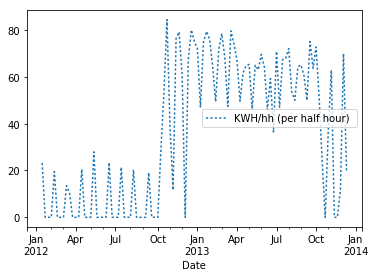

In [23]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])

In [24]:
day= data.resample(rule='H').sum()
day.head()

,KWH/hh (per half hour)
Date,
2012-01-11 00:00:00,0.318
2012-01-11 01:00:00,0.194
2012-01-11 02:00:00,0.167
2012-01-11 03:00:00,0.167
2012-01-11 04:00:00,0.212


### Moving average over 300 observation

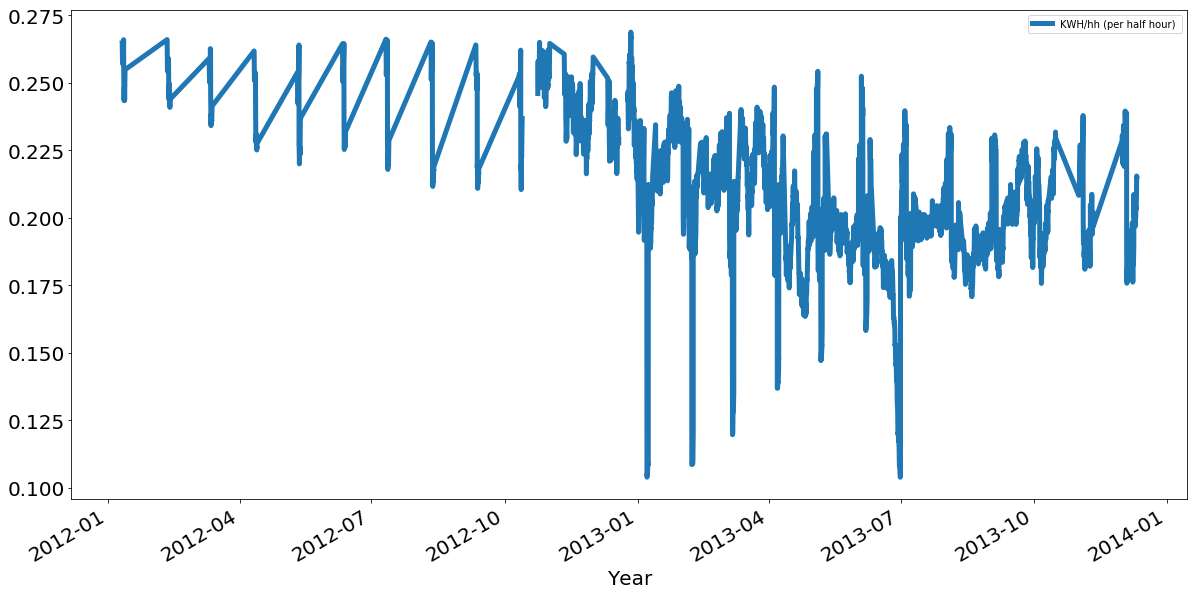

In [25]:
data.rolling(300).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [28]:
data.head()

,KWH/hh (per half hour)
Date,
2012-10-17 13:00:00,0.090
2012-10-17 13:30:00,0.160
2012-10-17 14:00:00,0.212
2012-10-17 14:30:00,0.145
2012-10-17 15:00:00,0.104


In [31]:
data["date"]= data.index

In [34]:
df = data.groupby(['date']).sum().reset_index()

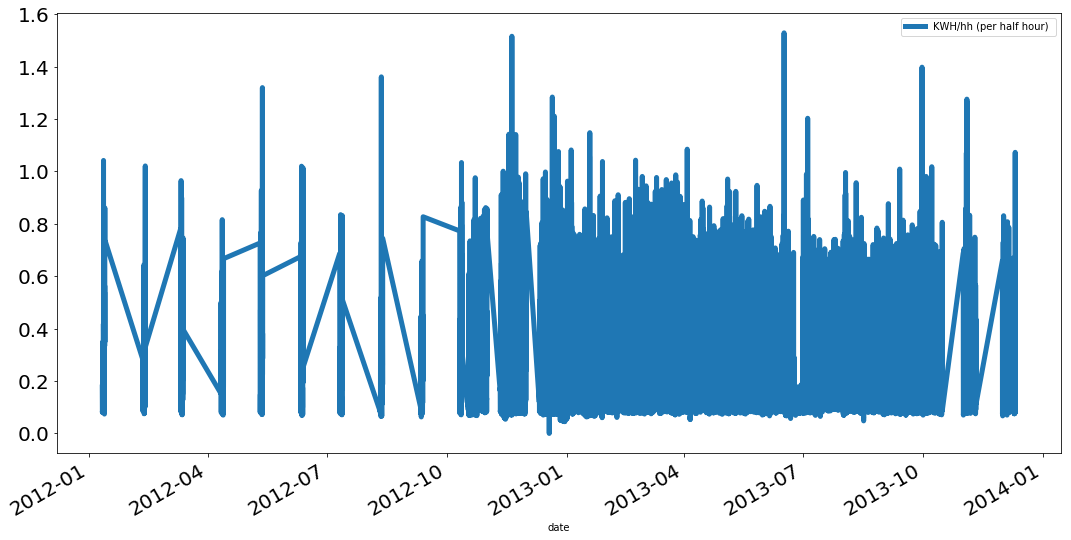

In [35]:
df.plot.line(x = 'date', y = 'KWH/hh (per half hour) ',  figsize=(18,9), linewidth=5, fontsize=20)
plt.show()

#### Month wise electricity consumption

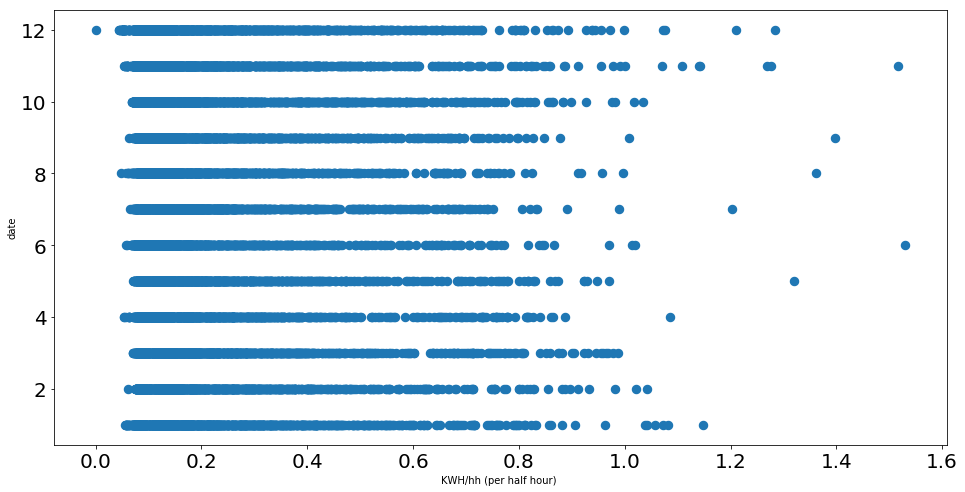

In [36]:
mon = df['date']
temp= pd.DatetimeIndex(mon)
month = pd.Series(temp.month)
to_be_plotted  = df.drop(['date'], axis = 1)
to_be_plotted = to_be_plotted.join(month)
to_be_plotted.plot.scatter(x = 'KWH/hh (per half hour) ', y = 'date', figsize=(16,8), linewidth=5, fontsize=20)
plt.show()

## LSTM

In [54]:
daily = data.resample('D').sum()

In [55]:
mydata=daily.loc[:, ['KWH/hh (per half hour) ']]
mydata = mydata.set_index(daily.index)
mydata.head()

,KWH/hh (per half hour)
Date,
2012-01-11,11.501
2012-01-12,11.687
2012-01-13,0.000
2012-01-14,0.000
2012-01-15,0.000


In [57]:
!pip install sklearn

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
#Use MinMaxScaler to normalize 'KWH/hh (per half hour) ' to range from 0 to 1

values = mydata['KWH/hh (per half hour) '].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

ImportError: DLL load failed: The specified module could not be found.